# Tutorial: The Canonical HANK Model in an Open Economy Setting

NBER Heterogeneous-Agent Macro Workshop

Michael Cai and Ludwig Straub

Spring 2022

We begin once more by importing packages.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import sequence_jacobian as sj

We again set the calibration up front.

In [2]:
calibration = {'eis': 1.,  # elasticity of intertemporal substitution
               'alpha': 0.4,  # home's foreign good preference, (1 - alpha) is the home's home bias
               'alphastar': 0.4,  # foreign's home good preference, (1 - alpha_star) is the foreign's home bias
               'eta': 1.01,  # elasticity of substitution between goods
               'gamma': 0.394,  # elasticity of foreign demand
               'markup_ss': 1.015,  # steady state markup
               'min_a': 0.,  # Minimum asset level on the grid
               'max_a': 400,  # Maximum asset level on the grid
               'n_a': 200,  # Number of asset grid points
               'rho_e': 0.92,  # persistence of idiosyncratic productivity shocks
               'sd_e': 0.57,  # standard deviation of idiosyncratic productivity shocks
               'n_e': 7,  # Number of income grid points
               'Y': 1,  # Output
               'A': 1,
               'C': 1,
               'nfa': 0,  # net foreign assets
               'rstar': 0.02,  # foreign interest rate
               'Cstar': 1,
               'Q': 1}  # Foreign demand

## Model setup

### `HetBlock` as before

We begin with the household block, which is defined exactly like we used it before! [copy & paste]

In [3]:
# initialize
def hh_init(a_grid, z, r, eis):
    coh = (1 + r) * a_grid[np.newaxis, :] + z[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    return Va

# backward step
@sj.het(exogenous='Pi',  # <-- this means our transition matrix will be fed into the model as Pi
        policy='a',  # <-- this means our endogenous state variable is a, defined over grid a_grid
        backward='Va',  # <-- this means we're iterating over variable Va, whose future value is Va_p
        backward_init=hh_init)
def hh(Va_p, a_grid, z, r, beta, eis):
    uc_nextgrid = beta * Va_p  # u'(c') on tomorrow's grid
    c_nextgrid = uc_nextgrid ** (-eis)  # c' on tomorrow's grid
    coh = (1 + r) * a_grid[np.newaxis, :] + z[:, np.newaxis]  # cash on hand coh on today's grid
    a = sj.interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)  # this plots (c'+a', a') pairs and computes policy a from interpolation on coh
    sj.misc.setmin(a, a_grid[0])  # impose borrowing constraint
    c = coh - a  # back out consumption
    Va = (1 + r) * c ** (-1 / eis)  # V'(a)
    return Va, a, c

Just like before, we set two `hetinputs` and a `hetoutput` for calculating MPCs. [copy & paste]

In [4]:
def make_grids(rho_e, sd_e, n_e, min_a, max_a, n_a):
    e_grid, _, Pi = sj.grids.markov_rouwenhorst(rho_e, sd_e, n_e)
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a)
    return e_grid, Pi, a_grid

def income(Z, e_grid):
    z = Z * e_grid
    return z

hh_ha = hh.add_hetinputs([make_grids, income])

### Other blocks

Here we list a few extra `SimpleBlock`s we need:

 - sectoral demand of domestic households:

 - foreign demand

 - UIP

 - income

 - balance of payments: (just to compute the NFA, not needed if we clear the goods market)

 - market clearing

We could allow for more here: Wage Phillips curve, Taylor rule, etc, but that is not necessary for what we are doing now, as long as we assume real interest rate rules.

Let's also set up the RA model.

In [191]:
@sj.solved(unknowns={'C': 1, 'A': 1},
           targets=["euler", "budget_constraint"])  # solver="broyden_custom")
def hh_ra(C, A, Z, eis, beta, r):
    euler = (beta * (1 + r(+1)))**(-eis) * C(+1) - C
    budget_constraint = (1 + r) * A(-1) + Z - C - A
    return euler, budget_constraint

ra = sj.create_model([UIP, income, hh_ra, dom_demand, for_demand, bop,  mkt_clearing], name="RA model")

## Steady state

## Calibration and model setup

We calibrate the model, just like before. First, we give it a test run, without calibrating anything.

Automate this ...

Now let's verify that Walras law and UIP hold:

What's `chi` here?

Let's calibrate the RA model too:

In [196]:
calibration_ra = calibration.copy()
calibration_ra['r_ante'] = calibration_ra['rstar']
calibration_ra['beta'] = 1 / (1 + calibration_ra['r_ante'])
calibration_ra['A'] = ss['A']

unknowns_ra_ss = {'C': 1., 'A': 0.8}
targets_ra_ss = {'budget_constraint': 0., 'asset_mkt': 0.}
ss_ra = ra.solve_steady_state(calibration_ra, unknowns_ra_ss, targets_ra_ss, dissolve=['hh_ra', 'UIP'])

print(ss_ra['asset_mkt'])
print(ss_ra['uip'])
print(ss_ra['goods_mkt'])

-7.577272143066693e-13
0.0
-4.0745185003743245e-14


## Transitional dynamics

We are now going to look at the impulse responses to two kinds of shocks:
1. Shocks to the foreign interest rate, $r^*$, interpreted as exchange rate shocks or capital flow shocks.
2. Shocks to the domestic interest rate, $r$, interpreted as domestic monetary policy shocks.

As before, we define a simple function to aid with plotting stuff.

In [197]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

### Shocks to the foreign interest rate, $r^*$

We use `solve_impulse_linear` just like before.

Let's plot those:

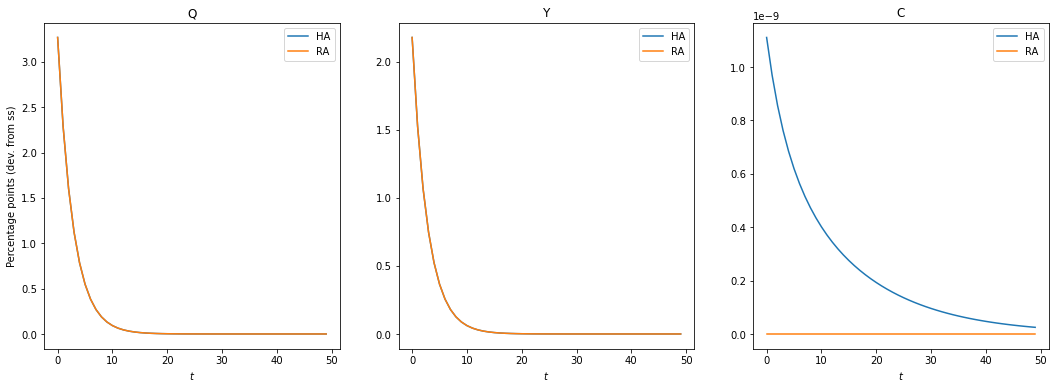

Why does consumption not move here? Despite `Y` moving? Let us also plot `Z`, `PH_P`:

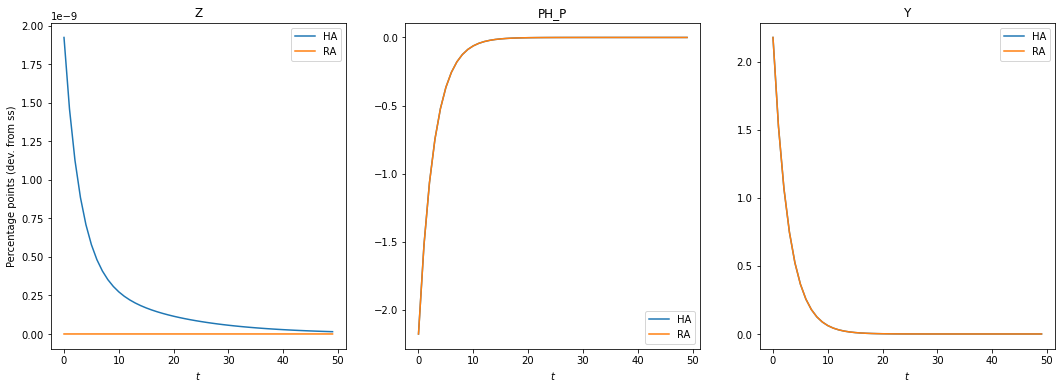

We see that real labor income Z is constant, because the real value of goods sold, `PH_P` falls due to the depreciation, exactly offsetting the increase in output `Y`.

We can learn more about the propagation by separating the `C` response into what would have happened with only `PH_P` falling ("real income channel") and with only the `Y` increase ("multiplier channel"). We do so by using the `impulse_linear` function.

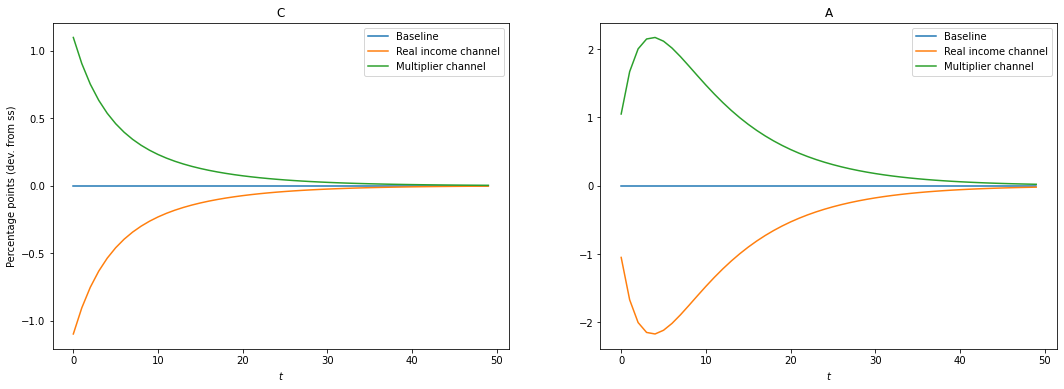

We see that what's going on is that the real income channel and the multiplier channel are exactly offsetting each other here.

Let's see what happens with greater and smaller `chi`s:

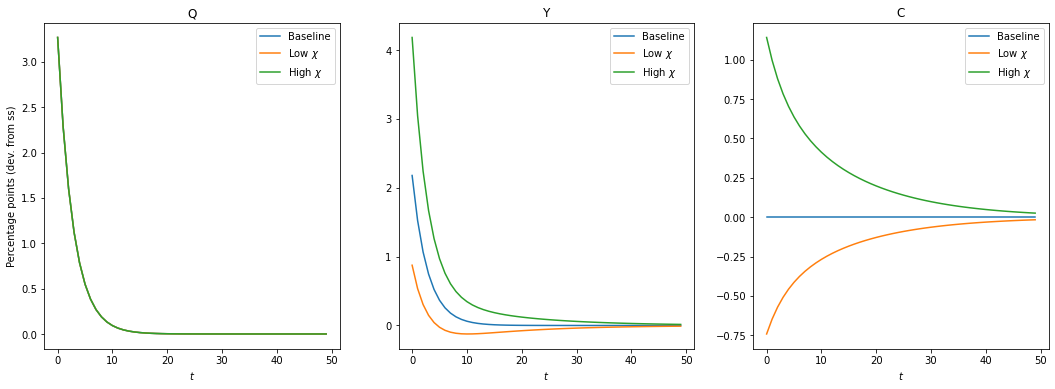

Repeating the decomposition for the case with low chi:

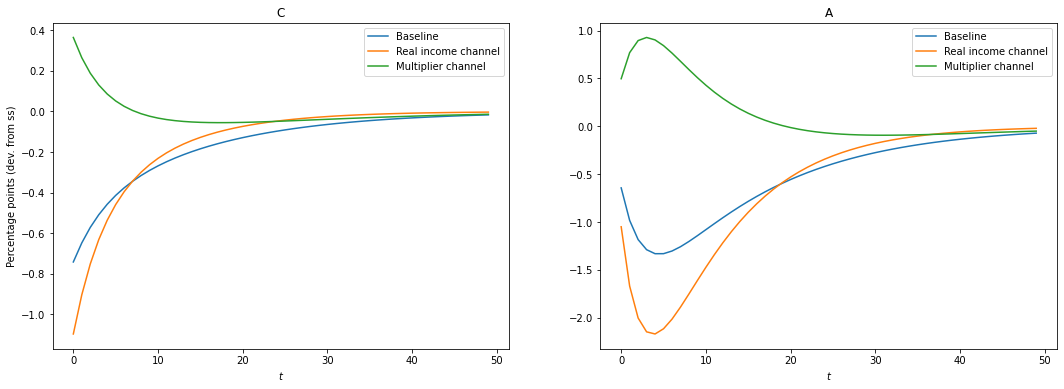

Here the real income channel dominates!

### Shocks to the domestic interest rate, r

Let's try out a domestic monetary policy shock. For that, let's set chi to 2 - alpha.

chi = 1.6


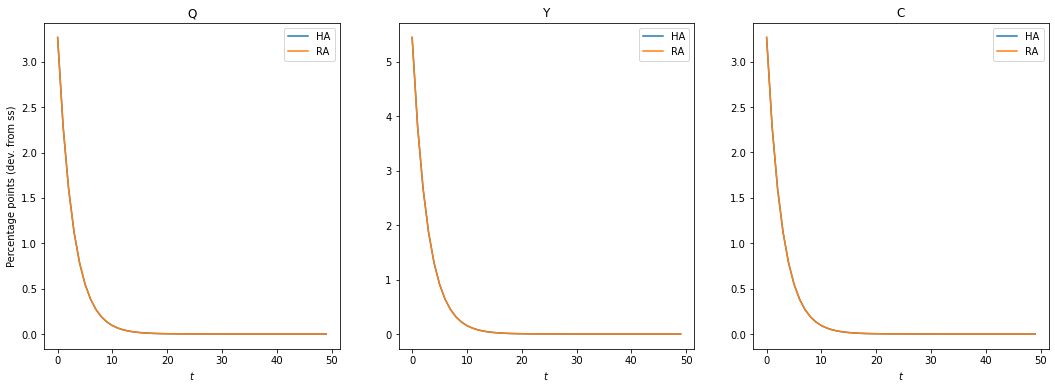

Notice that `Q` responds exactly the same here as it did to a positive `rstar` shock. But `Y` responds more, because `C` responds more.

Why is that? Let's decompose the `C` response once more.

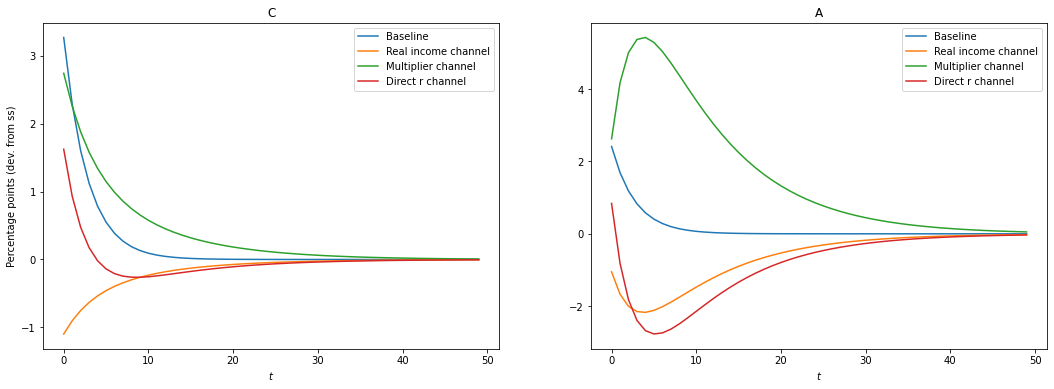

## Exercises

### Exercise 1: `Cstar` shocks

Compute the IRFs to an export demand shock, i.e. a shock to `Cstar`. Is there an effect on `C`? If so, why?

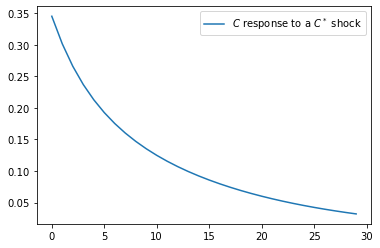

In [71]:
dCstar = 0.01 * 0.7 ** np.arange(T)

irfs_Cstar = ha.solve_impulse_linear(ss, unknowns_td, targets_td, {'Cstar': dCstar})

plt.plot(100 * irfs_Cstar['C'][:30], label=r'$C$ response to a $C^*$ shock')
plt.legend()
plt.show()

In [112]:
irfs_Cstar['C'][:5]

array([0.00345552, 0.00301739, 0.00266202, 0.00237168, 0.0021304 ])

In [73]:
J_hh = ha['hh'].jacobian(ss, ['Z', 'r'], T=T)
M = J_hh['C']['Z']
Mr = J_hh['C']['r']

In [115]:
(M @ irfs_Cstar['Y'])[:5]

array([0.00346012, 0.00301864, 0.00266104, 0.00236929, 0.0021272 ])

In [116]:
irfs_Cstar['r'][:5]

array([0.0006375, 0.       , 0.       , 0.       , 0.       ])

In [117]:
(Mr @ irfs_Cstar['r'])[:5]

array([4.65261112e-05, 4.33624178e-05, 4.03017556e-05, 3.74079791e-05,
       3.46409631e-05])

In [118]:
# irfs_Cstar['C'] - (M @ irfs_Cstar['Y'] + Mr @ irfs_Cstar['r'])  # can there be a revaluation effect on r with a Cstar shock?
(irfs_Cstar['C'] - M @ irfs_Cstar['Y'])[:5]

array([-4.60872409e-06, -1.24796961e-06,  9.76001584e-07,  2.39387169e-06,
        3.20455626e-06])

### Exercise 2: Domestic demand shocks

Compute the IRFs to a domestic demand shock, i.e. a shock to `beta`.

 (a) How different is a positive demand shock from an accommodative monetary policy shock?

 (b) Decompose the `C` response into the direct effect of the `beta` shock, and the indirect response via `Z`.
 
 (c) Simulate a shock to income risk, i.e. to `sd_e`. How different is a positive risk shock from a negative demand shock?

**Solution**

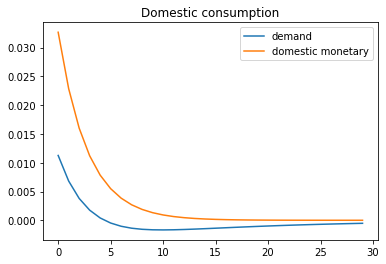

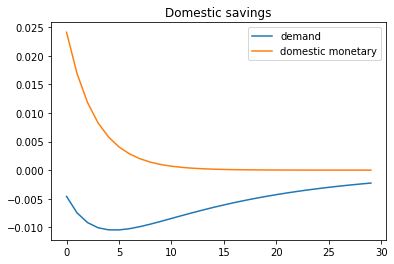

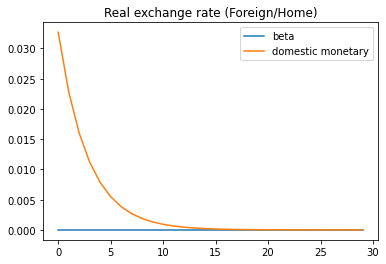

In [78]:
# a)
dbeta = -0.005 * 0.7 ** np.arange(T)
dr_ante = -0.01 * 0.7 ** np.arange(T)

irfs_beta = ha.solve_impulse_linear(ss, unknowns_td, targets_td, {'beta': dbeta})
irfs_r = ha.solve_impulse_linear(ss, unknowns_td, targets_td, {'r_ante': dr_ante})
irfs_r_pe = ha['hh'].impulse_linear(ss, {'r': dr_ante})

plt.title('Domestic consumption')
plt.plot(irfs_beta['C'][:30], label='demand')
plt.plot(irfs_r['C'][:30], label='domestic monetary')
plt.legend()
plt.show()

plt.title('Domestic savings')
plt.plot(irfs_beta['A'][:30], label='demand')
plt.plot(irfs_r['A'][:30], label='domestic monetary')
plt.legend()
plt.show()

plt.title('Real exchange rate (Foreign/Home)')
# plt.plot(irfs_beta['Q'][:30])  # Nothing happens here!
plt.plot(np.zeros(30), label='beta')
plt.plot(irfs_r['Q'][:30], label='domestic monetary')
plt.legend()
plt.show()

In [79]:
# b)
dC_direct = ha['hh'].impulse_linear(ss, {'beta': dbeta})['C']
# dC_indirect = (M @ irfs_beta['Y'] + Mr @ irfs_beta['r'])
dC_indirect = M @ irfs_beta['Y']

dC_manual = dC_direct + dC_indirect

In [119]:
dC_manual[:5]

array([0.01130622, 0.00684837, 0.00381807, 0.00177412, 0.00041401])

In [120]:
irfs_beta['C'][:5]

array([0.01126447, 0.00681838, 0.00379702, 0.00175985, 0.00040491])

In [121]:
(dC_manual - irfs_beta['C'])[:5]

array([4.17414531e-05, 2.99871585e-05, 2.10537594e-05, 1.42707092e-05,
       9.09248048e-06])

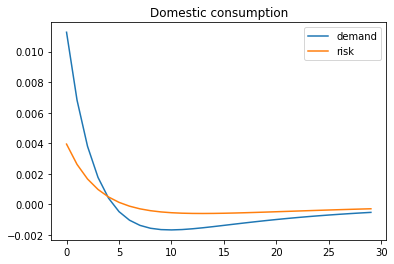

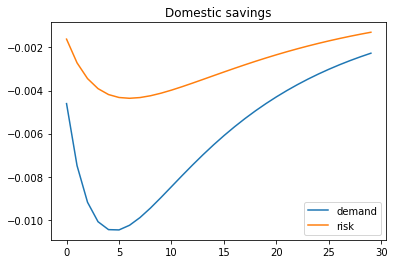

In [83]:
# c)
dsd_e = -0.01 * 0.7 ** np.arange(T)

irfs_sd = ha.solve_impulse_linear(ss, unknowns_td, targets_td, {'sd_e': dsd_e})

plt.title('Domestic consumption')
plt.plot(irfs_beta['C'][:30], label='demand')
plt.plot(irfs_sd['C'][:30], label='risk')
plt.legend()
plt.show()

plt.title('Domestic savings')
plt.plot(irfs_beta['A'][:30], label='demand')
plt.plot(irfs_sd['A'][:30], label='risk')
plt.legend()
plt.show()

### Exercise 3: UIP shocks

(a) Modify the model to introduce an exogenous UIP wedge and hit it with a shock. Compare it to the effect of an `rstar` shock, suitably rescaled, with the same persistence.

**Solution**

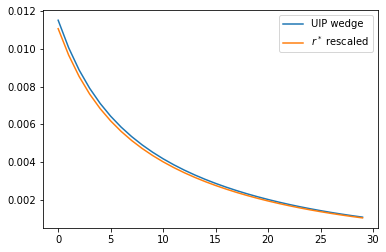

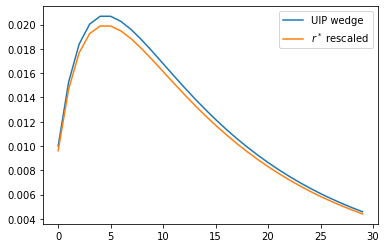

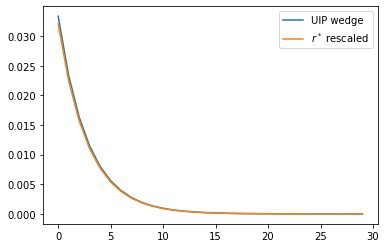

In [84]:
@sj.solved(unknowns={'Q': (0.1, 2)}, targets=['uip'])
def UIP_wedge(Q, r_ante, rstar, eta, alpha, gamma, uip_wedge):
    # recursive equation for UIP to pin down RER Q
    uip = Q / Q(1) * (1 + r_ante) * uip_wedge - (1 + rstar)

    # price of H goods abroad in terms of Q
    PHstar = ((Q ** (eta - 1) - alpha) / (1 - alpha)) ** (1 / (1 - eta))

    # price of H goods at home in terms of Q
    PH_P = ((1 - alpha * Q ** (1 - eta)) / (1 - alpha)) ** (1 / (1 - eta))

    # price of F goods at home in terms of Q
    PF_P = Q  # LOOP

    # let's also compute chi, as an important object in the theory
    chi = eta * (1-alpha) + gamma
    return uip, PHstar, PH_P, PF_P, chi

ha_uip_wedge = sj.create_model([UIP_wedge, income, hh_extended, dom_demand, for_demand, bop, mkt_clearing],
                               name="Canonical Open Economy HA Model w/ UIP wedge")

ss_uip_wedge = ss.copy()
ss_uip_wedge['uip_wedge'] = 1.

duip_wedge = -0.01 * 0.7 ** np.arange(T)
drstar_rescaled = drstar / (1 + ss['r_ante'])

irf_uip_wedge = ha_uip_wedge.solve_impulse_linear(ss_uip_wedge, unknowns_td, targets_td, {'uip_wedge': duip_wedge})
irf_rstar_rescaled = ha.solve_impulse_linear(ss, unknowns_td, targets_td, {'rstar': drstar_rescaled})

plt.plot(irf_uip_wedge['C'][:30], label='UIP wedge')
plt.plot(irf_rstar_rescaled['C'][:30], label=r'$r^*$ rescaled')
plt.legend()
plt.show()

plt.plot(irf_uip_wedge['A'][:30], label='UIP wedge')
plt.plot(irf_rstar_rescaled['A'][:30], label=r'$r^*$ rescaled')
plt.legend()
plt.show()

plt.plot(irf_uip_wedge['Q'][:30], label='UIP wedge')
plt.plot(irf_rstar_rescaled['Q'][:30], label=r'$r^*$ rescaled')
plt.legend()
plt.show()

In [85]:
irf_uip_wedge['r'][:1]

array([0.002125])

In [86]:
irf_rstar_rescaled['r'][:1]

array([0.00204248])

(b) Now make the UIP wedge endogenous to the NFA: Pick a simple affine linear function for the UIP wedge. How does the endogenous UIP wedge affect the propagation of `rstar` and `r` shocks? What if `chi` is low?

**Solution**

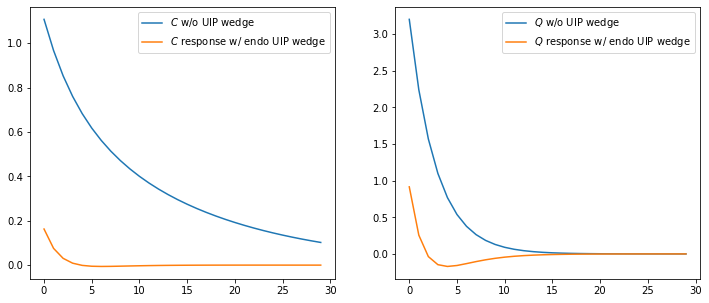

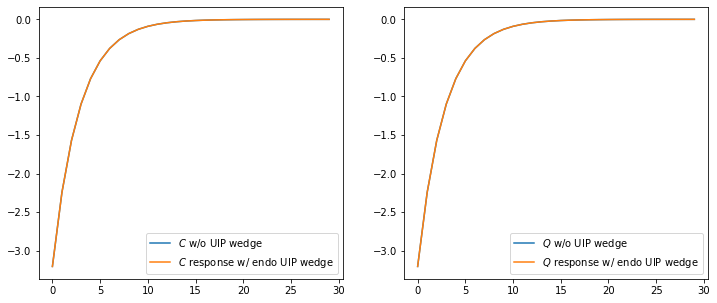

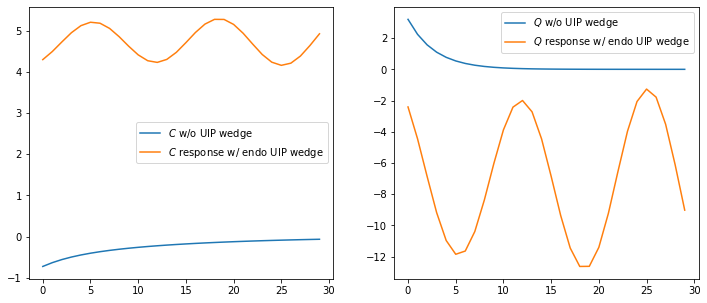

In [87]:
@sj.simple
def UIP_endo_wedge(Q, r_ante, rstar, uip_slope, nfa):
    # let the UIP wedge be an affine linear function of the NFA
    uip_wedge = 1 + uip_slope * nfa

    # recursive equation for UIP to pin down RER Q
    uip = Q / Q(1) * (1 + r_ante) * uip_wedge - (1 + rstar)
    return uip, uip_wedge


@sj.simple
def prices(Q, eta, alpha, gamma):
    # price of H goods abroad in terms of Q
    PHstar = ((Q ** (eta - 1) - alpha) / (1 - alpha)) ** (1 / (1 - eta))

    # price of H goods at home in terms of Q
    PH_P = ((1 - alpha * Q ** (1 - eta)) / (1 - alpha)) ** (1 / (1 - eta))

    # price of F goods at home in terms of Q
    PF_P = Q  # LOOP

    # let's also compute chi, as an important object in the theory
    chi = eta * (1-alpha) + gamma
    return PHstar, PH_P, PF_P, chi


ha_uip_endo_wedge = sj.create_model([UIP_endo_wedge, prices, income, hh_extended, dom_demand, for_demand, bop, mkt_clearing],
                                     name="Canonical Open Economy HA Model w/ endogenous UIP wedge")

ss_uip_endo_wedge = ss.copy()
# positive means when nfa up (foreign indebtedness up), lower r to raise Q (UIP lower r up implies domestic appreciation)
# think of the wedge as moving in the opposite direction of an r_ante that can undo it, a *dampening* force
ss_uip_endo_wedge['uip_slope'] = 1.

irf_rstar_rescaled_endo = ha_uip_endo_wedge.solve_impulse_linear(ss_uip_endo_wedge, unknowns_td + ['Q'], targets_td + ['uip'],
                                                                 {'rstar': drstar_rescaled})

irf_rante_rescaled = ha.solve_impulse_linear(ss, unknowns_td, targets_td, {'r_ante': drstar_rescaled})
irf_rante_rescaled_endo = ha_uip_endo_wedge.solve_impulse_linear(ss_uip_endo_wedge, unknowns_td + ['Q'], targets_td + ['uip'],
                                                                  {'r_ante': drstar_rescaled})

ss_lowchi_uip_endo_wedge = ss_lowchi.copy()
ss_lowchi_uip_endo_wedge['uip_slope'] = 1.
irf_lowchi_rstar_rescaled = ha.solve_impulse_linear(ss_lowchi, unknowns_td, targets_td, {'rstar': drstar_rescaled})
irf_lowchi_rstar_rescaled_endo = ha_uip_endo_wedge.solve_impulse_linear(ss_lowchi_uip_endo_wedge, unknowns_td + ['Q'],
                                                                        targets_td + ['uip'], {'rstar': drstar_rescaled})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(100 * irf_rstar_rescaled['C'][:30], label=r'$C$ w/o UIP wedge')
ax1.plot(100 * irf_rstar_rescaled_endo['C'][:30], label=r'$C$ response w/ endo UIP wedge')
ax1.legend()
ax2.plot(100 * irf_rstar_rescaled['Q'][:30], label=r'$Q$ w/o UIP wedge')
ax2.plot(100 * irf_rstar_rescaled_endo['Q'][:30], label=r'$Q$ response w/ endo UIP wedge')
ax2.legend()
plt.show()

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))
ax3.plot(100 * irf_rante_rescaled['C'][:30], label=r'$C$ w/o UIP wedge')
ax3.plot(100 * irf_rante_rescaled_endo['C'][:30], label=r'$C$ response w/ endo UIP wedge')
ax3.legend()
ax4.plot(100 * irf_rante_rescaled['Q'][:30], label=r'$Q$ w/o UIP wedge')
ax4.plot(100 * irf_rante_rescaled_endo['Q'][:30], label=r'$Q$ response w/ endo UIP wedge')
ax4.legend()
plt.show()

fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(12, 5))
ax5.plot(100 * irf_lowchi_rstar_rescaled['C'][:30], label=r'$C$ w/o UIP wedge')
ax5.plot(100 * irf_lowchi_rstar_rescaled_endo['C'][:30], label=r'$C$ response w/ endo UIP wedge')
ax5.legend()
ax6.plot(100 * irf_lowchi_rstar_rescaled['Q'][:30], label=r'$Q$ w/o UIP wedge')
ax6.plot(100 * irf_lowchi_rstar_rescaled_endo['Q'][:30], label=r'$Q$ response w/ endo UIP wedge')
ax6.legend()
plt.show()

In [122]:
irf_lowchi_rstar_rescaled['nfa'][:5]

array([-0.00550755, -0.0089693 , -0.01103207, -0.01214335, -0.01261394])

In [123]:
irf_rante_rescaled_endo['nfa'][:5]

array([-4.03141302e-07, -2.23422606e-07, -4.07944499e-07, -2.58556271e-07,
       -1.29209147e-07])

### Exercise 4: MPCs

Add an option to compute MPCs, just like we did before, as `hetoutput`. Compute MPCs in this steady state. Have the model recalibrate the steady state markup `markup_ss` to hit a quarterly MPC of 0.25.

**Solution**

In [90]:
ss_mpc = ha.solve_steady_state(calibration, {'beta': ss['beta'], 'markup_ss': ss['markup_ss']}, {'asset_mkt': 0., 'MPC': 0.25},
                               dissolve=['UIP'])
print(f"The beta and markup_ss that correspond to asset market clearing and a quarterly MPC of 0.25 are:\nbeta = {ss['beta']},"
      f" and markup_ss = {ss['markup_ss']}")

The beta and markup_ss that correspond to asset market clearing and a quarterly MPC of 0.25 are:
beta = 0.946538992380244, and markup_ss = 1.015


### Exercise 5: Comparison to RA and TA

Just like before, introduce RA and TA models. Compare the HA IRFs to the ones in the RA and TA models. Show that they coincide for `rstar` shocks when `chi=1` but can differ significantly otherwise.

**Solution**

In [91]:
@sj.solved(unknowns={'C': 1, 'A': 1},
           targets=["euler", "budget_constraint"])  # solver="broyden_custom")
def hh_ra(C, A, Z, eis, beta, r):
    euler = (beta * (1 + r(+1)))**(-eis) * C(+1) - C
    budget_constraint = (1 + r) * A(-1) + Z - C - A
    return euler, budget_constraint

ra = sj.create_model([hh_ra, UIP, income, dom_demand, for_demand, bop, mkt_clearing], name="Representative agent open economy model")


@sj.solved(unknowns={'C_RA': 1, 'A': 1},
           targets=["euler", "budget_constraint"])  # , solver="broyden_custom")
def hh_ta(C_RA, A, Z, eis, beta, r, lam):
    euler = (beta * (1 + r(+1))) ** (-eis) * C_RA(+1) - C_RA      # consumption of infinitely lived household
    C_H2M = Z   # computes consumption of an hand to mouth agent
    C = (1 - lam) * C_RA + lam * C_H2M
    budget_constraint = (1 + r) * A(-1) + Z - C - A
    return euler, budget_constraint, C_H2M, C

ta = sj.create_model([hh_ta, UIP, income, dom_demand, for_demand, bop, mkt_clearing], name="Two agent open economy model")

In [92]:
calibration_ra = calibration.copy()
calibration_ra['beta'] = 1 / (1 + calibration_ra['r_ante'])
calibration_ra['gamma'] = 1 - calibration_ra['eta'] * (1 - calibration_ra['alpha'])

unknowns_ra_ss = {'C': 1., 'A': 0.8}
targets_ra_ss = {'budget_constraint': 0., 'asset_mkt': 0.}

ss_ra = ra.solve_steady_state(calibration_ra, {'C': 1., 'A': 0.8}, {'budget_constraint': 0., 'asset_mkt': 0.},
                              dissolve=['hh_ra', 'UIP'])

calibration_ta = calibration_ra.copy()
calibration_ta['lam'] = 0.25
unknowns_ta_ss = {'C_RA': 1., 'A': 0.8}

ss_ta = ta.solve_steady_state(calibration_ta, {'C_RA': 1., 'A': 0.8}, {'budget_constraint': 0., 'asset_mkt': 0.},
                              dissolve=['hh_ta', 'UIP'])

calibration_ha_neutr = calibration.copy()
calibration_ha_neutr['gamma'] = 1 - calibration['eta'] * (1 - calibration['alpha'])
ss_ha_neutr = ha.solve_steady_state(calibration_ha_neutr, {'beta': (0.85, 0.95)}, ['asset_mkt'], dissolve=['UIP'])

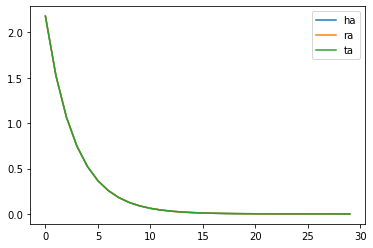

In [93]:
irf_ha_neutr = ha.solve_impulse_linear(ss_ha_neutr, unknowns_td, targets_td, {'rstar': drstar})
irf_ra = ra.solve_impulse_linear(ss_ra, unknowns_td, targets_td, {'rstar': drstar})
irf_ta = ta.solve_impulse_linear(ss_ta, unknowns_td, targets_td, {'rstar': drstar})

plt.plot(100 * irf_ha_neutr['Y'][:30], label='ha')
plt.plot(100 * irf_ra['Y'][:30], label='ra')
plt.plot(100 * irf_ta['Y'][:30], label='ta')
plt.legend()
plt.show()

### Exercise 6: Phillips curve and Taylor rule

(a) Introduce a standard wage Phillips curve into the model. Plot the response of nominal wage inflation to an `rstar` shock.

(b) Add a Taylor rule, which pins down the real rate as a function of domestic inflation. How does the response to `rstar` shocks change with a Taylor rule compared to a real rate rule? Interpret.

**Solution**

In [94]:
@sj.simple
def nkpc(pi, Y, X, C, theta_w, vphi, frisch, markup_ss, eis, beta):
    kappa_w = (1 - theta_w) * (1 - beta * theta_w)/theta_w
    piw = pi + X - X(-1)
    piwres = kappa_w * (vphi * (Y/X)**(1/frisch) - 1/markup_ss * X * C**(-1/eis)) + beta * piw(1) - piw
    return piwres, piw


@sj.simple
def monetary_taylor(pi, ishock, rss, phi_pi):
    i = rss + phi_pi * pi + ishock
    r_ante = i - pi(1)
    return i, r_ante

In [95]:
calibration_taylor = calibration.copy()
calibration_taylor.update({'X': 1., 'rss': calibration['r_ante'], 'pi': 0., 'ishock': 0.,
                           'phi_pi': 1.5, 'theta_w': 0.66, 'frisch': 0.5, 'markup_ss': 1.015})

In [96]:
ha_pc = sj.create_model([hh_extended, UIP, income, dom_demand, for_demand, bop, nkpc, mkt_clearing],
                        name="Open Economy HA Model w/ Phillips curve")
ha_taylor = sj.create_model([hh_extended, UIP, income, dom_demand, for_demand, bop, nkpc, monetary_taylor, mkt_clearing],
                            name="Open Economy HA Model w/ Taylor Rule")

ss_pc = ha_pc.solve_steady_state(calibration_taylor, {'beta': 0.95, 'vphi': 0.8}, ['asset_mkt', 'piwres'], dissolve=['UIP'])
ss_taylor = ha_taylor.solve_steady_state(calibration_taylor, {'beta': 0.95, 'vphi': 0.8}, ['asset_mkt', 'piwres'], dissolve=['UIP'])

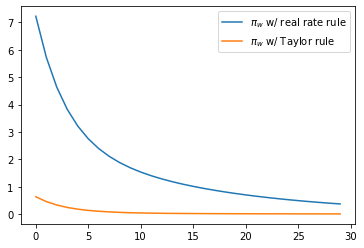

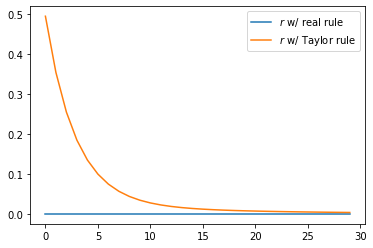

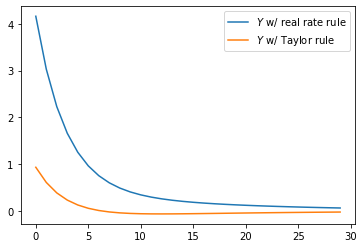

In [97]:
irf_pc = ha_pc.solve_impulse_linear(ss_taylor, unknowns_td + ['pi'], targets_td + ['piwres'], {'rstar': drstar})
irf_taylor = ha_taylor.solve_impulse_linear(ss_taylor, unknowns_td + ['pi'], targets_td + ['piwres'], {'rstar': drstar})

plt.plot(100 * irf_pc['piw'][:30], label=r"$\pi_w$ w/ real rate rule")
plt.plot(100 * irf_taylor['piw'][:30], label=r"$\pi_w$ w/ Taylor rule")
plt.legend()
plt.show()

plt.plot(np.zeros(30), label=r"$r$ w/ real rule")
plt.plot(100 * irf_taylor['r_ante'][:30], label=r"$r$ w/ Taylor rule")
plt.legend()
plt.show()

plt.plot(100 * irf_pc['Y'][:30], label=r"$Y$ w/ real rate rule")
plt.plot(100 * irf_taylor['Y'][:30], label=r"$Y$ w/ Taylor rule")
plt.legend()
plt.show()